In [85]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [86]:
df = pd.read_csv('Data.csv', low_memory=False)
df.head()

,Unnamed: 0,ATP,B365L,B365W,Best of,Comment,Court,Date,L1,L2,...,Tournament,W1,W2,W3,W4,W5,WPts,WRank,Winner,Wsets
0,0,1,NaN,NaN,3,Completed,Outdoor,03-01-2000,4.0,2,...,Australian Hardcourt Championships,6.0,6,NaN,NaN,NaN,NaN,63,Dosedel S.,2.0
1,1,1,NaN,NaN,3,Completed,Outdoor,03-01-2000,3.0,3,...,Australian Hardcourt Championships,6.0,6,NaN,NaN,NaN,NaN,5,Enqvist T.,2.0
2,2,1,NaN,NaN,3,Completed,Outdoor,03-01-2000,7.0,5,...,Australian Hardcourt Championships,6.0,7,6,NaN,NaN,NaN,40,Escude N.,2.0
3,3,1,NaN,NaN,3,Completed,Outdoor,03-01-2000,1.0,4,...,Australian Hardcourt Championships,6.0,6,NaN,NaN,NaN,NaN,65,Federer R.,2.0
4,4,1,NaN,NaN,3,Completed,Outdoor,03-01-2000,6.0,7,...,Australian Hardcourt Championships,7.0,5,6,NaN,NaN,NaN,81,Fromberg R.,2.0


In [87]:
#####DATA CLEANING#####

#Drop first unnamed col and also the second 'ATP' col as it does not seem relevant here
df = df.drop(['Unnamed: 0', 'ATP'], axis=1)

In [88]:
# Drop NaN values from Bet365 odds col (either L or W col should do) - dataframe will reduce from ~55k rows to ~46k rows
df = df[df['B365L'].notna()]

# A lot of sets have no games won by a player - replacing NaN values in such occurrences with 0
df[['L1', 'L2', 'L3', 'L4', 'L5', 'W1', 'W2', 'W3', 'W4', 'W5']] = df[['L1', 'L2', 'L3', 'L4', 'L5', 'W1', 'W2', 'W3', 'W4', 'W5']].fillna(0)

# 'B365W' (23 rows), 'LRank' (82 rows), 'Lsets' (235 rows), 'WRank' (16 rows), 'Wsets' (234 rows) all have null
# values - dropping these rows as they constitute a very small % of the overall dataset
df = df.dropna(subset = ['B365W', 'LRank', 'Lsets', 'WRank', 'Wsets'])

# 'LPts' and 'WPts' (which refers to ranking points of the winners and losers) are missing from about 8k rows, as it seems 
# the points system started only from 2005 onwards. Dropping these represents a significant chunk of the dataset, so an
# approximation needs to be used. One way to do so would be to take the average rating points of all other players with the
# same rank throughout the data set.

# However, dataset is large enough to absorb this hit. For now, dropping the rows mentioned above, and the model will be 
# re-run later again after applying a function to approximate these 2 cols with missing values, just to check if it results
# in greater accuracy. For now, the dataframe is reduced to 38k rows and includes data from only 2005 (from when ranking points
# were given out).
df = df.dropna(subset = ['LPts', 'WPts'])

# A lot of cols are objects as they are a mix of floats, strings (sometimes containing integers), and Nans.
# 'Comment' has 6 unique values with most of them simply being 'Completed', though some have other values like 'Retired'
# 'Walkover', 'Awarded' etc. Of the 38k rows in the dataset, 36.7k have 'Completed', 1.2k have 'Retired', 1 has 'Disqualified',
# 1 has 'Awarded', 6 have 'Walkover', and 2 have 'Sched'. So we can drop the latter 4 out of these 6 and apply one hot encoding
# for only the top two most frequent values. For the sake of simplicity, just mapping the comment to values, though the data on
# this coloumn should not have much bearing on the accuracy of this particular project.

df = df[(df['Comment'] != 'Disqualified') & (df['Comment'] != 'Walkover') & (df['Comment'] != 'Awarded')
        & (df['Comment'] != 'Sched')]

df['Comment'] = df['Comment'].map({'Completed': 1, 'Retired': 0})

# 'Court' has just 2 values - 'Indoor' and 'Outdoor' so we can apply a simple map
df['Court'] = df['Court'].map({'Indoor': 1, 'Outdoor': 0})

# 'Date' shouldn't have relevant data for projections here. Perhaps, long shots tend to happen more in certain seasons than
# others, but seasons depend on the hemisphere. Or maybe when player is in a hot run in a short space of time. However, rather
# than go engineer that much detail, for the sake of simplicity, I'm simply substituting date with cols for month & year.
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Month'] = pd.DatetimeIndex(df['Date']).month
df = df.drop('Date', axis=1)

# 'L2' & 'L3' have a lot of empty values including NaN's, or the integer values stored as strings, so these will have to
# all be converted to floats

df['L2'] = df['L2'].replace(r'^\s*$', 0, regex=True) # Replaces empty strings with 0
df['L2'] = df['L2'].fillna(0) # Replace NaN values with 0
df['L2'] = df['L2'].apply(lambda x: float(x)) # Convert strings to floats

df['L3'] = df['L3'].replace(r'^\s*$', 0, regex=True) # Replaces empty strings with 0
df['L3'] = df['L3'].fillna(0) # Replace NaN values with 0
df['L3'] = df['L3'].apply(lambda x: float(x)) # Convert strings to floats

# 'LRank' (Losing Player Rank) & 'WRank (Winning Player Rank)' have only one data type ('str') so these will also have to be
# converted to floats
df['LRank'] = df['LRank'].apply(lambda x: float(x)) # Convert strings to floats
df['WRank'] = df['WRank'].apply(lambda x: float(x)) # Convert strings to floats

# 'Location' does not have any value unless paired with the home country of the winning player, to see if home advantage
# plays a role - but that data is not available here, hence dropping this col.
df = df.drop('Location', axis=1)

# 'Winner' & 'Loser' player names will be required for exploratory data analysis so leaving these cols alone for now. Will
# delete them before applying model.

# 'Lsets' also has its values stored as strings so these need to be converted to floats
df = df[df['Lsets'] != '`1'] #Deleting the one row where Lset value was mistakenly entered as `1
df['Lsets'] = df['Lsets'].apply(lambda x: float(x)) # Convert strings to floats

# 'Round' simply refers to which round the game was played at and can be mapped to integers simply
df['Round'] = df['Round'].map({'1st Round': 1, '2nd Round': 2, 'Quarterfinals': 5, 'Semifinals': 6,
       'The Final': 7, '3rd Round': 3, '4th Round': 4, 'Round Robin': 0})

# 'Series' refers to the type of tournament and can be mapped to integers as well since there's just 8 unique strings
df['Series'] = df['Series'].map({'International': 7, 'International Gold': 6, 'Masters': 2, 'Grand Slam': 1, 
                                 'Masters Cup': 8, 'ATP250': 5, 'ATP500': 4, 'Masters 1000': 3})

# 'Surface' also has just 4 values so can be mapped simply
df['Surface'] = df['Surface'].map({'Clay': 2, 'Grass': 3, 'Hard': 1, 'Carpet': 4})

# 'Tournament' name is irrelevant, and 'Series' has similar info, so dropping this col
df = df.drop('Tournament', axis=1)

# 'W2' & 'W3' also have integer values stored as strings, like 'L2' & 'L3' so these will have to all be converted to floats
# as well - should've written a function for this, for now just making do with copy/paste.

df['W2'] = df['W2'].replace(r'^\s*$', 0, regex=True) # Replaces empty strings with 0
df['W2'] = df['W2'].apply(lambda x: float(x)) # Convert strings to floats

df['W3'] = df['W3'].replace(r'^\s*$', 0, regex=True) # Replaces empty strings with 0
df['W3'] = df['W3'].apply(lambda x: float(x)) # Convert strings to floats

#Below used to check final results#
# df.isnull().sum() 
# df.info()
# df.head(5)




In [89]:
#####EXPLORATORY DATA ANALYSIS#####

long_shot = 3.0 #setting long shot odds to 3.0

# Creating separate dataframe only with winners whose odds were long shots
df_long = df[df['B365W'] >= long_shot]

# From this new dataframe, dropping unnecessary cols for this particular stat - these cols are not relevant for co-relation
# col_list = list(df_long.columns) # Used to get list of cols to prevent typos
df_EDA = df_long.drop(['B365L', 'Comment', 'L1', 'L2', 'L3', 'L4', 'L5', 'LPts', 'LRank', 'Loser', 'Lsets', 'W1', 'W2',
                        'W3', 'W4', 'W5', 'WPts', 'WRank', 'Winner', 'Wsets'], axis=1)

<AxesSubplot:>

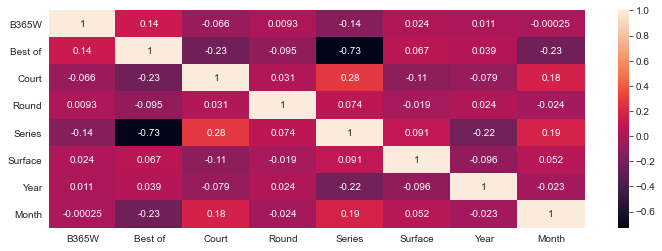

In [90]:
#####EXPLORATORY DATA ANALYSIS#####

# Q. Are long shot odds (>= 3.0) strongly corelated with any feature?

# Set figure size for graphs
plt.figure(figsize=(12,4))

df_heatmap = df_EDA.corr()
sns.heatmap(data=df_heatmap, annot=True)

# A. No

In [91]:
df_EDA.head()

,B365W,Best of,Court,Round,Series,Surface,Year,Month
16211,3.50,3,0,2,7,2,2005,6
16216,3.00,3,0,2,7,2,2005,7
16226,7.50,3,0,1,7,2,2005,5
16239,6.50,3,0,1,7,2,2005,5
16242,3.25,3,0,2,7,2,2005,6


Percentage of long shot odds winning in outdoor matches:  9.773393933533185
Percentage of long shot odds winning in indoor matches:  10.044869011434361


<AxesSubplot:xlabel='Court', ylabel='Percent'>

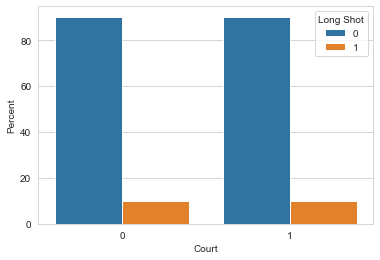

In [92]:
#####EXPLORATORY DATA ANALYSIS#####

# Q. Are long shot odds more likely to happen in Outdoor or Indoor courts?

#Overall frequency of Odds vs Court:

# plt.figure(figsize=(10,8))
# sns.histplot(y='B365W', x='Court', data=df_EDA, legend=True)
# plt.xlabel("Court (0: Outdoor, 1: Indoor)")
# plt.ylabel("Bet365 Odds")

#Since frequency is a bit skewed (due to many more matches being played Outdoors), let's go by the %:

a = len(df[df['Court'] == 0]) # Total no. of outdoor matches
b = len(df[(df['Court'] == 0) & (df['B365W'] >= long_shot)]) # Total no. of outdoor matches where winner had long shot odds
ls_out_pct = (b*100)/a

x = len(df[df['Court'] == 1]) # Total no. of indoor matches
y = len(df[(df['Court'] == 1) & (df['B365W'] >= long_shot)]) # Total no. of indoor matches where winner had long shot odds
ls_ind_pct = (y*100)/x

print('Percentage of long shot odds winning in outdoor matches: ', ls_out_pct)
print('Percentage of long shot odds winning in indoor matches: ', ls_ind_pct)

# A. Practically no difference - long shot odds won in 9.77% of outdoor matches and 10.04% of indoor matches

# Let's see this result visually:

df['Long Shot'] = df['B365W'].apply(lambda x: 1 if x >= long_shot else 0) # Create new col with value=1 if long shot wins
sns.set_style('whitegrid')
tempdf = df.groupby('Court')['Long Shot'].value_counts(normalize=True) # New temp df with containing only relevant values
tempdf = tempdf.mul(100).rename('Percent').reset_index() # Multiplying values by 100 as 'normalize' sets value between 0 & 1

# 'Indoor': 1, 'Outdoor': 0
sns.barplot(x='Court', y='Percent', hue='Long Shot', data=tempdf)



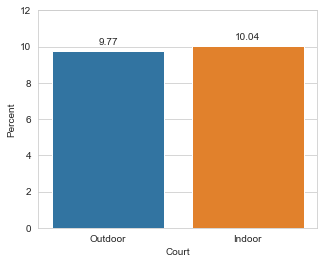

In [93]:
# Below graph contains only the long shot odds % and is only for exploratory analysis and readme
data = {'Court': ['Outdoor', 'Indoor'], 'Percent': [ls_out_pct, ls_ind_pct]} #Data for df with only relevant data
dfblog = pd.DataFrame(data)
plt.figure(figsize=(5,4))
plt.ylim(0,12)

splot= sns.barplot(x='Court', y='Percent', data=dfblog)

# Function to display values on top of bars
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')    
plt.show()

<AxesSubplot:xlabel='Series', ylabel='Percent'>

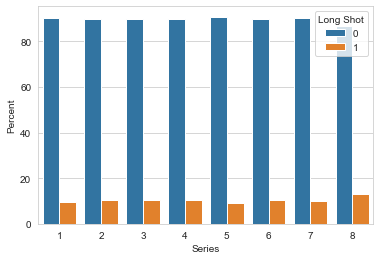

In [94]:
#####EXPLORATORY DATA ANALYSIS#####

# Q. Do any series favor long shot odds?

sns.set_style('whitegrid')
tempdf = df.groupby('Series')['Long Shot'].value_counts(normalize=True) # New temp df with containing only relevant values
tempdf = tempdf.mul(100).rename('Percent').reset_index() # Multiplying values by 100 as 'normalize' sets value between 0 & 1

# Codes: 'International': 7, 'International Gold': 6, 'Masters': 2, 'Grand Slam': 1, 'Masters Cup': 8, 'ATP250': 5,
# 'ATP500': 4, 'Masters 1000': 3
sns.barplot(x='Series', y='Percent', hue='Long Shot', data=tempdf)

# A. It's all roughly similar, though there is a slightly greater chance of long shots in Masters Cup events - however, sample
# size for these type of tournaments is just 221 which may be the reason for the slight skew (13% vs 10% for the others)

<ipython-input-95-b2bf693b2e95>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf1['Series'] = tempdf1['Series'].map({7: 'International', 6:'International Gold', 2: 'Masters', 1: 'Grand Slam', 8: 'Masters Cup', 5: 'ATP250', 4: 'ATP500', 3: 'Masters 1000'})


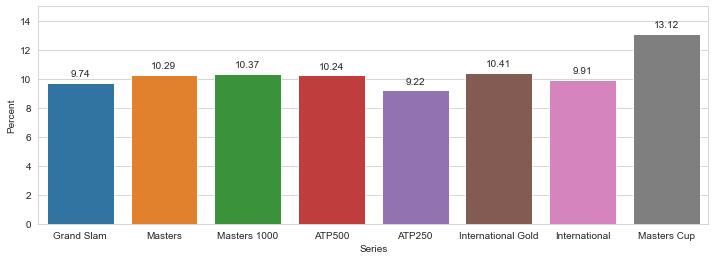

In [95]:
# Below graph contains only the long shot odds % and is only for the EDA/readme

sns.set_style('whitegrid')
tempdf1 = tempdf[tempdf['Long Shot'] == 1] # New df with only long-shot percentages in it

# Labeling so it is displayed in graph
tempdf1['Series'] = tempdf1['Series'].map({7: 'International', 6:'International Gold', 2: 'Masters', 1: 'Grand Slam', 8: 'Masters Cup', 5: 'ATP250', 4: 'ATP500', 3: 'Masters 1000'})

plt.figure(figsize=(12,4))
plt.ylim(0,15)

splot= sns.barplot(x='Series', y='Percent', data=tempdf1)

# Function to display values on top of bars
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')    
plt.show()

<AxesSubplot:xlabel='Surface', ylabel='Percent'>

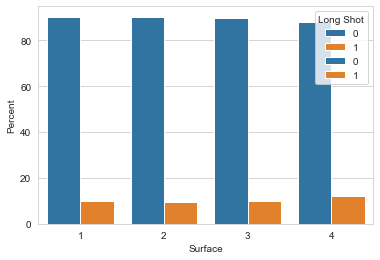

In [96]:
#####EXPLORATORY DATA ANALYSIS#####

# Q. Do any surfaces favor long shot odds? What about court type?

sns.set_style('whitegrid')
tempdf = df.groupby('Court')['Long Shot'].value_counts(normalize=True) # New temp df with containing only relevant values
tempdf = tempdf.mul(100).rename('Percent').reset_index() # Multiplying values by 100 as 'normalize' sets value between 0 & 1

# Codes: 'Indoor': 1, 'Outdoor': 0
sns.barplot(x='Court', y='Percent', hue='Long Shot', data=tempdf)

sns.set_style('whitegrid')
tempdf = df.groupby('Surface')['Long Shot'].value_counts(normalize=True) # New temp df with containing only relevant values
tempdf = tempdf.mul(100).rename('Percent').reset_index() # Multiplying values by 100 as 'normalize' sets value between 0 & 1

# Codes: 'Clay': 2, 'Grass': 3, 'Hard': 1, 'Carpet': 4
sns.barplot(x='Surface', y='Percent', hue='Long Shot', data=tempdf)

# A. No major different in court type (outdoor or indoor). There is slightly greater chance of long shots in 'Carpet' surfaces
# (12% vs approx 10% for all the others) - however, here # again sample size for 'Carpet' matches is only 780 which may be 
# the reason for the skew.

<ipython-input-97-853eedc09c8f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf1['Surface'] = tempdf1['Surface'].map({2: 'Clay', 3: 'Grass', 1: 'Hard', 4: 'Carpet'})


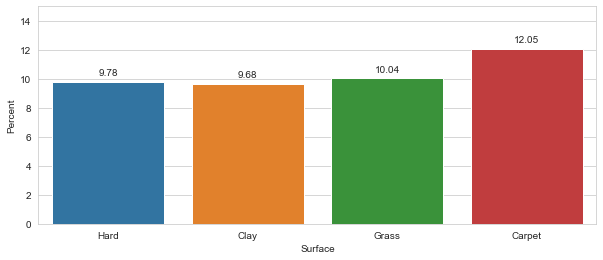

In [97]:
# Below graph contains only the long shot odds % and is only for the EDA/readme

sns.set_style('whitegrid')
tempdf1 = tempdf[tempdf['Long Shot'] == 1] # New df with only long-shot percentages in it

# Labeling so it is displayed in graph
tempdf1['Surface'] = tempdf1['Surface'].map({2: 'Clay', 3: 'Grass', 1: 'Hard', 4: 'Carpet'})

plt.figure(figsize=(10,4))
plt.ylim(0,15)

splot= sns.barplot(x='Surface', y='Percent', data=tempdf1)

# Function to display values on top of bars
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')    
plt.show()

<AxesSubplot:xlabel='Best of', ylabel='Percent'>

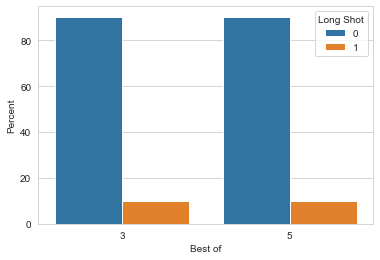

In [98]:
#####EXPLORATORY DATA ANALYSIS#####

# Q. Do length of matches (3-set or 5-set) have any bearing on succesful long shot odds?

sns.set_style('whitegrid')
tempdf = df.groupby('Best of')['Long Shot'].value_counts(normalize=True) # New temp df with containing only relevant values
tempdf = tempdf.mul(100).rename('Percent').reset_index() # Multiplying values by 100 as 'normalize' sets value between 0 & 1


sns.barplot(x='Best of', y='Percent', hue='Long Shot', data=tempdf)

# A. No difference between 3-set and 5-set matches.

<ipython-input-99-8466e150207f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf1['Best of'] = tempdf1['Best of'].map({3: '3 sets', 5: '5 sets'})


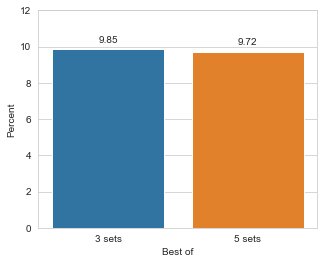

In [99]:
# Below graph contains only the long shot odds % and is only for the EDA/readme

sns.set_style('whitegrid')
tempdf1 = tempdf[tempdf['Long Shot'] == 1] # New df with only long-shot percentages in it

# Labeling so it is displayed in graph
tempdf1['Best of'] = tempdf1['Best of'].map({3: '3 sets', 5: '5 sets'})

plt.figure(figsize=(5,4))
plt.ylim(0,12)

splot= sns.barplot(x='Best of', y='Percent', data=tempdf1)

# Function to display values on top of bars
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')    
plt.show()

<AxesSubplot:xlabel='Round', ylabel='Percent'>

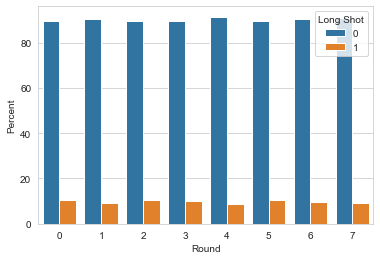

In [100]:
# Q. Does the stage of the tournament (ie which round it is) have any bearing on succesful long shot odds?

sns.set_style('whitegrid')
tempdf = df.groupby('Round')['Long Shot'].value_counts(normalize=True) # New temp df with containing only relevant values
tempdf = tempdf.mul(100).rename('Percent').reset_index() # Multiplying values by 100 as 'normalize' sets value between 0 & 1

# Codes: '1st Round': 1, '2nd Round': 2, 'Quarterfinals': 5, 'Semifinals': 6, 'The Final': 7, '3rd Round': 3, '4th Round': 4,
#'Round Robin': 0
sns.barplot(x='Round', y='Percent', hue='Long Shot', data=tempdf)

# A. It's all roughly similar - there is slight decrease in chance of long shots in the 4th round (8.5% vs 10%) but overall, 
# it's roughly similar.

<ipython-input-101-a2034397c2c0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf1['Round'] = tempdf1['Round'].map({1: 'Round 1', 2: 'Round 2', 5: 'QF', 6: 'SF',


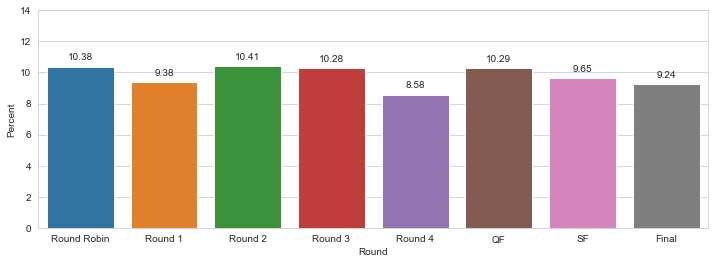

In [101]:
# Q. Are long shot odds more likely to happen in any particular round of the tournamen?

# Below graph contains only the long shot odds % and is only for the EDA/readme

sns.set_style('whitegrid')
tempdf1 = tempdf[tempdf['Long Shot'] == 1] # New df with only long-shot percentages in it

# Labeling so it is displayed in graph
tempdf1['Round'] = tempdf1['Round'].map({1: 'Round 1', 2: 'Round 2', 5: 'QF', 6: 'SF',
       7: 'Final', 3: 'Round 3', 4: 'Round 4', 0: 'Round Robin'})

plt.figure(figsize=(12,4))
plt.ylim(0,14)

splot= sns.barplot(x='Round', y='Percent', data=tempdf1)

# Function to display values on top of bars
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')    
plt.show()

<AxesSubplot:xlabel='Month', ylabel='Percent'>

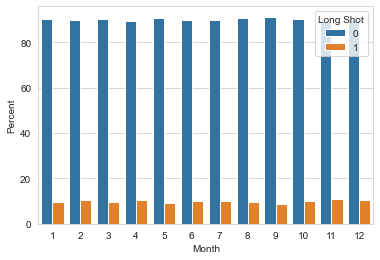

In [102]:
# Q. Do succesful long shot odds occur in particular months of the year?

sns.set_style('whitegrid')
tempdf = df.groupby('Month')['Long Shot'].value_counts(normalize=True) # New temp df with containing only relevant values
tempdf = tempdf.mul(100).rename('Percent').reset_index() # Multiplying values by 100 as 'normalize' sets value between 0 & 1

sns.barplot(x='Month', y='Percent', hue='Long Shot', data=tempdf)

# A. No, the chance of long shots are independent of the month with all being within one percentage point of each other. There
# is a very slight uptick in chance in the (northern hemisphere) winter months of Nov & Dec

<ipython-input-103-d819f845618a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf1['Month'] = tempdf1['Month'].map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',


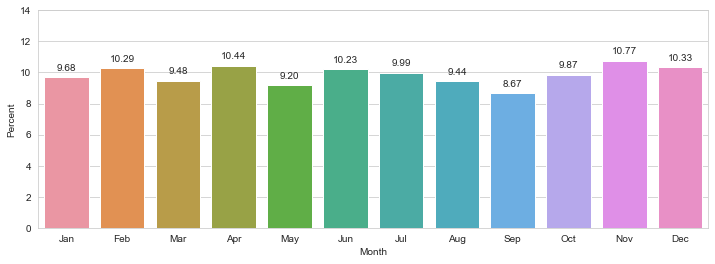

In [103]:
# Are long shot odds more likely to happen in any particular month of the year?

# Below graph contains only the long shot odds % and is only for the blog

sns.set_style('whitegrid')
tempdf1 = tempdf[tempdf['Long Shot'] == 1] # New df with only long-shot percentages in it

# Labeling so it is displayed in graph
tempdf1['Month'] = tempdf1['Month'].map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
                                        9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})

plt.figure(figsize=(12,4))
plt.ylim(0,14)

splot= sns.barplot(x='Month', y='Percent', data=tempdf1)

# Function to display values on top of bars
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')    
plt.show()

<AxesSubplot:xlabel='Best of', ylabel='Percent'>

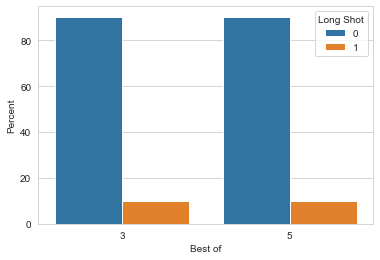

In [104]:
# Q. Do succesful long shot odds tend to occur in 3 set or 5 set games?

sns.set_style('whitegrid')
tempdf = df.groupby('Best of')['Long Shot'].value_counts(normalize=True) # New temp df with containing only relevant values
tempdf = tempdf.mul(100).rename('Percent').reset_index() # Multiplying values by 100 as 'normalize' sets value between 0 & 1

sns.barplot(x='Best of', y='Percent', hue='Long Shot', data=tempdf)

# A. No difference - equal chance in both.

<AxesSubplot:xlabel='Rank Difference', ylabel='Count'>

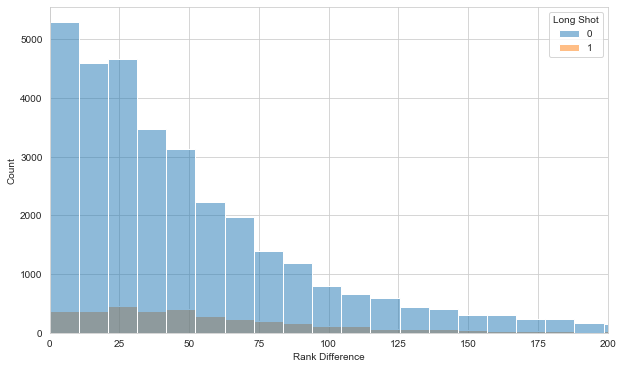

In [105]:
# Q. What difference in rankings/points between players favor long shot odds winning?

# df_EDA['Rank Difference'] = df['WRank'] - df['LRank'] # New col containing rank difference between winner and loser

# sns.set_style('whitegrid')
# plt.xlim(-200,200) # Set x-axis limit to make graph readable
# sns.histplot(x='Rank Difference', bins=90, data=df_EDA)

df['Rank Difference'] = df['WRank'] - df['LRank'] # New col containing rank difference between winner and loser

df['Rank Difference'] = df['Rank Difference'].apply(lambda x: (x**2)**0.5) # Taking sqrt of squares to make values +ve

sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.xlim(0,200) # Set x-axis limit to make graph readable
sns.histplot(x='Rank Difference', hue='Long Shot', bins=200, data=df)

# A. While it is intuitive that bookies will only offer long shot odds when the difference in rank is significant, still 
# there appears to be greater % chance of long shot coming good when rank difference is between the 35 to 60 mark - this 
# looks like it could be an important feature.

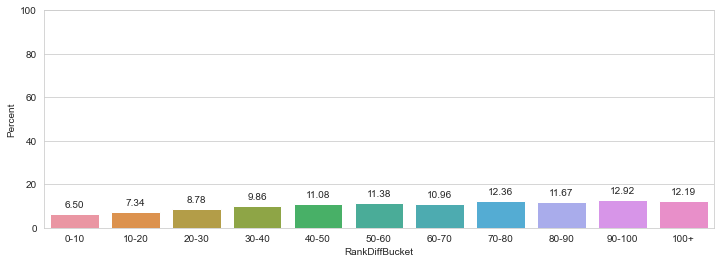

In [106]:
# Graph displaying percentage of long shots by rank difference of the players

# Below graph contains only the long shot odds % and is only for the EDA/readme

bins = [0,10,20,30,40,50,60,70,80,90,100,1000] # Specifying bins for rank difference
binname = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100+'] # Bin names
df['RankDiffBucket'] = pd.cut(df['Rank Difference'], bins, labels=binname) # Applying bucket

sns.set_style('whitegrid')
tempdf = df.groupby('RankDiffBucket')['Long Shot'].value_counts(normalize=True) # New temp df with containing only relevant values
tempdf = tempdf.mul(100).rename('Percent').reset_index() # Multiplying values by 100 as 'normalize' sets value between 0 & 1

tempdf1 = tempdf[tempdf['Long Shot'] == 1] # New df with only long-shot percentages in it

plt.figure(figsize=(12,4))
plt.ylim(0,100)

splot= sns.barplot(x='RankDiffBucket', y='Percent', data=tempdf1)

# Function to display values on top of bars
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')    
plt.show()


<ipython-input-107-55031bfce612>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf['RankDiffBucket'] = pd.cut(tempdf['Rank Difference'], bins, labels=binname)


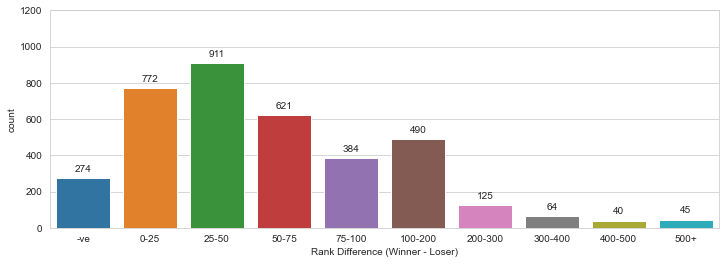

In [107]:
# Reanalyzing the Rank Difference count data as it was not done correctly

# df = df.drop(['RankDiffBucket'], axis=1)
df['Rank Difference'] = df['WRank'] - df['LRank'] # New col containing rank difference between loser and winner

tempdf = df[df['Long Shot'] == 1] # New df with only long-shot percentages in it

bins = [-5000,0,25,50,75,100,200,300,400,500,5000] # Specifying bins for rank difference
binname = ['-ve', '0-25', '25-50', '50-75', '75-100', '100-200', '200-300', '300-400', '400-500','500+'] # Bin names
tempdf['RankDiffBucket'] = pd.cut(tempdf['Rank Difference'], bins, labels=binname)

# tempdf1 = tempdf.groupby('RankDiffBucket')['Long Shot'].value_counts(normalize=True) # New temp df with containing only relevant values
# tempdf = tempdf.mul(100).rename('Percent').reset_index()
tempdf.head()

plt.figure(figsize=(12,4))
plt.ylim(0,1200)

splot= sns.countplot(x='RankDiffBucket', data=tempdf)
splot.set(xlabel='Rank Difference (Winner - Loser)')

# Function to display values on top of bars
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')    
plt.show()



In [108]:
##### EDA did not show any feature strongly corelated to long shot odds, except perhaps that if long shot odds are being
##### offered when rank difference is between 35 and 60 (approx), it may make more sense to take it. A possible thing to try
##### would be feature engineering new columns - for example, favorite surface and winning streak (form). For now, let's try
##### to build a model with the existing features to see if long shots odds can be predicted at a better rate than expected.

In [109]:
df.columns

Index(['B365L', 'B365W', 'Best of', 'Comment', 'Court', 'L1', 'L2', 'L3', 'L4',
       'L5', 'LPts', 'LRank', 'Loser', 'Lsets', 'Round', 'Series', 'Surface',
       'W1', 'W2', 'W3', 'W4', 'W5', 'WPts', 'WRank', 'Winner', 'Wsets',
       'Year', 'Month', 'Long Shot', 'Rank Difference', 'RankDiffBucket'],
      dtype='object')

In [110]:
# Let's drop the cols which are not useful for making a prediction:
# The pre-match odds themselves should have no bearing so we can drop 'B365L', 'B365W'
# The set scores of a match should also have no effect so we can drop 'L1', 'L2', 'L3', 'L4', 'L5', 'W1', 'W2', 'W3', 'W4', 'W5'
# Likewise we can drop 'Lsets', 'Wsets'
# The 'LPts', 'WPts' are related to the ranks so we can drop these
# The rank difference already takes into account 'WRank' and 'LRank' so we can drop this as well
# The winner and loser name is also irrelevant so we can drop 'Winner' and 'Loser'

In [111]:
dfmodel = df.drop(['B365L', 'B365W', 'L1', 'L2', 'L3', 'L4', 'L5', 'W1', 'W2', 'W3', 'W4', 'W5', 'Lsets', 'Wsets', 'LPts', 'WPts', 'WRank', 'LRank', 'Winner', 'Loser'], axis=1)
dfmodel.head()

,Best of,Comment,Court,Round,Series,Surface,Year,Month,Long Shot,Rank Difference,RankDiffBucket
16194,3,1,0,1,7,2,2005,4,0,-92.0,90-100
16195,3,1,0,1,7,2,2005,4,0,785.0,100+
16196,3,1,0,1,7,2,2005,5,0,-82.0,80-90
16197,3,1,0,1,7,2,2005,5,0,-105.0,100+
16198,3,1,0,1,7,2,2005,5,0,-29.0,20-30


In [112]:
# Dropping RankDiffBucket so that just Rank Difference col is retained
dfmodel = dfmodel.drop(['RankDiffBucket'], axis = 1)
dfmodel.head()

,Best of,Comment,Court,Round,Series,Surface,Year,Month,Long Shot,Rank Difference
16194,3,1,0,1,7,2,2005,4,0,-92.0
16195,3,1,0,1,7,2,2005,4,0,785.0
16196,3,1,0,1,7,2,2005,5,0,-82.0
16197,3,1,0,1,7,2,2005,5,0,-105.0
16198,3,1,0,1,7,2,2005,5,0,-29.0


In [113]:
dfmodel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37932 entries, 16194 to 54907
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Best of          37932 non-null  int64  
 1   Comment          37932 non-null  int64  
 2   Court            37932 non-null  int64  
 3   Round            37932 non-null  int64  
 4   Series           37932 non-null  int64  
 5   Surface          37932 non-null  int64  
 6   Year             37932 non-null  int64  
 7   Month            37932 non-null  int64  
 8   Long Shot        37932 non-null  int64  
 9   Rank Difference  37932 non-null  float64
dtypes: float64(1), int64(9)
memory usage: 3.2 MB


In [70]:
++
# Long Shot: Whether long shot won (1) or didn't (0)

In [114]:
# Moving Long Shot col to the end
df1 = dfmodel.pop('Long Shot')
dfmodel['Long Shot'] = df1
dfmodel.head()

,Best of,Comment,Court,Round,Series,Surface,Year,Month,Rank Difference,Long Shot
16194,3,1,0,1,7,2,2005,4,-92.0,0
16195,3,1,0,1,7,2,2005,4,785.0,0
16196,3,1,0,1,7,2,2005,5,-82.0,0
16197,3,1,0,1,7,2,2005,5,-105.0,0
16198,3,1,0,1,7,2,2005,5,-29.0,0


In [115]:
# First let's scale the data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(dfmodel.drop('Long Shot',axis=1))
scaled_features = scaler.transform(dfmodel.drop('Long Shot',axis=1))
df_feat = pd.DataFrame(scaled_features,columns=dfmodel.columns[:-1])
df_feat.head()


,Best of,Comment,Court,Round,Series,Surface,Year,Month,Rank Difference
0,-0.483572,0.183834,-0.471917,-0.741774,1.609807,0.518194,-1.721592,-0.606589,-0.475358
1,-0.483572,0.183834,-0.471917,-0.741774,1.609807,0.518194,-1.721592,-0.606589,6.456860
2,-0.483572,0.183834,-0.471917,-0.741774,1.609807,0.518194,-1.721592,-0.291283,-0.396314
3,-0.483572,0.183834,-0.471917,-0.741774,1.609807,0.518194,-1.721592,-0.291283,-0.578116
4,-0.483572,0.183834,-0.471917,-0.741774,1.609807,0.518194,-1.721592,-0.291283,0.022623


In [119]:
# Adding back Long Shot coloumn at the end

df_feat['Long Shot'] = dfmodel['Long Shot']
df_feat['Long Shot'].value_counts()

0.0    19090
1.0     2082
Name: Long Shot, dtype: int64

In [120]:
# Splitting data into train and test sets with the 'Long Shot' col used for the classification.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dfmodel.drop('Long Shot',axis=1), 
                                                    dfmodel['Long Shot'], test_size=0.30, 
                                                    random_state=101)

In [121]:
# Applying a simple logistic regression model on the data and get predictions

from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)


In [122]:
# Model evaluation 

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,predictions))
print('\n')
print(confusion_matrix(y_test,predictions))


              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10295
           1       0.43      0.10      0.16      1085

    accuracy                           0.90     11380
   macro avg       0.67      0.54      0.55     11380
weighted avg       0.87      0.90      0.87     11380



[[10155   140]
 [  980   105]]


In [123]:
#Random Forest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,rfc_pred))
print('\n')
print(confusion_matrix(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     10295
           1       0.42      0.24      0.31      1085

    accuracy                           0.90     11380
   macro avg       0.67      0.60      0.62     11380
weighted avg       0.88      0.90      0.88     11380



[[9929  366]
 [ 823  262]]
